In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from numba import njit
from scipy.interpolate import BarycentricInterpolator
from itertools import product
from tqdm import tqdm
import plotly.express as px
import plotly.graph_objects as go

In [2]:
def load_file(fp) :
    mi = np.fromfile(fp, dtype = '<u8')
    mat = np.zeros((mi.shape[0], 6), dtype = "u4") 
    mat[:,0] = mi & 31 # tdc, 0-4 (5)
    mat[:,1] = (mi & 131040) >> 5 # bx, 5-16 (12)
    mat[:,2] = (mi & 562949953290240) >> 17 # orbit, 17-48 (32)
    mat[:,3] = (mi & 287667426198290432) >> 49 # chan, 49-57 (9)
    mat[:,4] = (mi & 2017612633061982208) >> 58 # fpga (3)
    mat[:,5] = mi >> 61

    return mat

In [3]:
tipi = {'tdc':'u1', 'bx':'u2', 'orbit':'u4', 'chan':'u2', 'fpga':'u1', 'head':'u1'}

m = load_file('data/data_000000.dat')
df = pd.DataFrame(m, columns = ['tdc', 'bx', 'orbit', 'chan', 'fpga', 'head'])

df_file2 = pd.DataFrame(load_file('data/data_000001.dat'), columns = ['tdc', 'bx', 'orbit', 'chan', 'fpga', 'head'])
df = pd.concat([df, df_file2])

del df_file2

df = df.astype(tipi)
df

,tdc,bx,orbit,chan,fpga,head
0,0,0,4079645633,100,1,1
1,2,4064,4079645602,100,1,0
2,23,1476,4079645568,100,1,4
3,16,653,4079645568,100,1,5
4,2,2922,3387200947,75,0,2
...,...,...,...,...,...,...
1310715,10,2269,10532461,27,1,2
1310716,2,3325,10532452,122,0,2
1310717,27,471,10532456,122,0,2
1310718,10,1753,10532458,89,0,2


In [4]:
# rimuovo head diverso da 2
df = df[df['head'] == 2]
df

,tdc,bx,orbit,chan,fpga,head
4,2,2922,3387200947,75,0,2
5,29,2227,3387200955,105,0,2
6,7,2234,3387200955,107,0,2
7,29,476,3387200973,126,0,2
8,12,1797,3387200955,55,1,2
...,...,...,...,...,...,...
1310715,10,2269,10532461,27,1,2
1310716,2,3325,10532452,122,0,2
1310717,27,471,10532456,122,0,2
1310718,10,1753,10532458,89,0,2


In [5]:
# tengo le orbite con 3 <= n < 16 hits
s = df.groupby('orbit').size()
s1 = s[(s > 2) & (s < 16)].index
df = df[df.orbit.isin(s1)]
df

,tdc,bx,orbit,chan,fpga,head
7,29,476,3387200973,126,0,2
11,28,475,3387200973,90,1,2
20,16,485,3387200973,124,0,2
21,5,480,3387200973,127,0,2
24,18,481,3387200973,42,1,2
...,...,...,...,...,...,...
1310700,29,1245,10532373,100,1,2
1310701,3,1247,10532373,98,1,2
1310702,9,1250,10532373,101,1,2
1310703,17,1256,10532373,99,1,2


In [6]:
# troppa poca pazienza?
df1 = df#[:len(df)//100]
df1

,tdc,bx,orbit,chan,fpga,head
7,29,476,3387200973,126,0,2
11,28,475,3387200973,90,1,2
20,16,485,3387200973,124,0,2
21,5,480,3387200973,127,0,2
24,18,481,3387200973,42,1,2
...,...,...,...,...,...,...
1310700,29,1245,10532373,100,1,2
1310701,3,1247,10532373,98,1,2
1310702,9,1250,10532373,101,1,2
1310703,17,1256,10532373,99,1,2


In [7]:
tipi

{'tdc': 'u1',
 'bx': 'u2',
 'orbit': 'u4',
 'chan': 'u2',
 'fpga': 'u1',
 'head': 'u1'}

In [8]:
def scintillatore(gruppo) :
    if ((gruppo['fpga'] == 1) & (gruppo['chan'] == 128)).any() :
        return gruppo
    else:
        return None

tipi = {'tdc':'u1', 'bx':'u2', 'orbit':'u4', 'chan':'u2', 'fpga':'u1', 'head':'u1'}
df2 = df1.groupby('orbit').apply(scintillatore).dropna().astype(tipi) # dopo apply casta tutto a float per essere compatibile con il None, credo. Per evitare un recast e risparmiare memoria si può usare una flag diversa da None/np.nan MA mi secco per un test del cavolo
df2

,tdc,bx,orbit,chan,fpga,head
1305966,15,2890,10515923,108,0,2
1320,30,1852,5802635,111,1,2
1321,4,1855,5802635,37,1,2
1322,18,1855,5802635,128,1,2
1336,16,1856,5802635,120,0,2
...,...,...,...,...,...,...
1305961,17,2877,10515923,42,1,2
1305962,11,2879,10515923,43,1,2
1305964,24,2875,10515923,107,0,2
1305965,20,2878,10515923,37,0,2


In [15]:
ds = pd.read_csv('s.csv')
ds

,tdc,bx,orbit,chan,fpga,head
0,27,878,1118948,91,1,2
1,8,882,1118948,107,0,2
2,18,881,1118948,47,1,2
3,12,884,1118948,88,1,2
4,7,881,1118948,128,1,2
...,...,...,...,...,...,...
10187,17,2877,10515923,42,1,2
10188,11,2879,10515923,43,1,2
10189,24,2875,10515923,107,0,2
10190,20,2878,10515923,37,0,2


In [19]:
o1, o2 = np.unique(ds.orbit, return_counts = True)
n1, n2 = np.unique(df2.orbit, return_counts = True)

In [22]:
np.count_nonzero(o1 == n1) == len(o1)

True

In [23]:
np.count_nonzero(o2 == n2) == len(o2)

False

In [28]:
oo = o1[np.nonzero(o2 != n2)[0][0]]
oo

10515923

In [29]:
df2[df2.orbit == oo]

,tdc,bx,orbit,chan,fpga,head
1305966,15,2890,10515923,108,0,2
1305946,17,2867,10515923,41,1,2
1305947,19,2868,10515923,128,1,2
1305951,24,2865,10515923,34,0,2
1305952,19,2865,10515923,35,0,2
1305953,5,2879,10515923,36,0,2
1305954,18,2873,10515923,105,0,2
1305955,2,2880,10515923,108,0,2
1305960,29,2868,10515923,40,1,2
1305961,17,2877,10515923,42,1,2


In [30]:
ds[ds.orbit == oo]

,tdc,bx,orbit,chan,fpga,head
10179,17,2867,10515923,41,1,2
10180,19,2868,10515923,128,1,2
10181,24,2865,10515923,34,0,2
10182,19,2865,10515923,35,0,2
10183,5,2879,10515923,36,0,2
10184,18,2873,10515923,105,0,2
10185,2,2880,10515923,108,0,2
10186,29,2868,10515923,40,1,2
10187,17,2877,10515923,42,1,2
10188,11,2879,10515923,43,1,2


In [32]:
print(len(df2[df2.orbit == oo]))
print(len(ds[ds.orbit == oo]))

14
13


In [37]:
df1.sort_values('orbit')

,tdc,bx,orbit,chan,fpga,head
391,28,544,617095,48,0,2
390,12,542,617095,45,0,2
389,5,538,617095,47,0,2
388,20,532,617095,46,0,2
421,24,3410,617129,96,0,2
...,...,...,...,...,...,...
311,13,1730,3387201636,47,0,2
324,2,1737,3387201636,126,0,2
325,5,1738,3387201636,42,0,2
326,23,1741,3387201636,127,0,2


In [38]:
df1

,tdc,bx,orbit,chan,fpga,head
7,29,476,3387200973,126,0,2
11,28,475,3387200973,90,1,2
20,16,485,3387200973,124,0,2
21,5,480,3387200973,127,0,2
24,18,481,3387200973,42,1,2
...,...,...,...,...,...,...
1310700,29,1245,10532373,100,1,2
1310701,3,1247,10532373,98,1,2
1310702,9,1250,10532373,101,1,2
1310703,17,1256,10532373,99,1,2


In [39]:
df2.sort_values('orbit')

,tdc,bx,orbit,chan,fpga,head
6694,5,887,1118948,46,1,2
6691,14,881,1118948,44,1,2
6690,7,881,1118948,128,1,2
6689,12,884,1118948,88,1,2
6688,18,881,1118948,47,1,2
...,...,...,...,...,...,...
1305947,19,2868,10515923,128,1,2
1305946,17,2867,10515923,41,1,2
1305965,20,2878,10515923,37,0,2
1305953,5,2879,10515923,36,0,2


In [33]:
df2s = df1.sort_values('orbit').groupby('orbit').apply(scintillatore).dropna().astype(tipi) # dopo apply casta tutto a float per essere compatibile con il None, credo. Per evitare un recast e risparmiare memoria si può usare una flag diversa da None/np.nan MA mi secco per un test del cavolo
df2s

,tdc,bx,orbit,chan,fpga,head
1305947,19,2868,10515923,128,1,2
1320,30,1852,5802635,111,1,2
1321,4,1855,5802635,37,1,2
1322,18,1855,5802635,128,1,2
1338,12,1865,5802635,123,0,2
...,...,...,...,...,...,...
1305962,11,2879,10515923,43,1,2
1305964,24,2875,10515923,107,0,2
1305965,20,2878,10515923,37,0,2
1305966,15,2890,10515923,108,0,2


In [34]:
df2s.sort_values('orbit')

,tdc,bx,orbit,chan,fpga,head
6689,12,884,1118948,88,1,2
6692,17,883,1118948,90,1,2
6693,1,891,1118948,138,1,2
6694,5,887,1118948,46,1,2
6695,12,889,1118948,89,1,2
...,...,...,...,...,...,...
1305951,24,2865,10515923,34,0,2
1305946,17,2867,10515923,41,1,2
1305966,15,2890,10515923,108,0,2
1305954,18,2873,10515923,105,0,2


In [40]:
da = df1.copy()
da = da[da.orbit.isin(da[(da.fpga == 1) & (da.chan == 128)].orbit)]
da

,tdc,bx,orbit,chan,fpga,head
6683,27,878,1118948,91,1,2
6687,8,882,1118948,107,0,2
6688,18,881,1118948,47,1,2
6689,12,884,1118948,88,1,2
6690,7,881,1118948,128,1,2
...,...,...,...,...,...,...
1305961,17,2877,10515923,42,1,2
1305962,11,2879,10515923,43,1,2
1305964,24,2875,10515923,107,0,2
1305965,20,2878,10515923,37,0,2


In [41]:
x = pd.read_csv('s1.csv')
x

,tdc,bx,orbit,chan,fpga,head
0,25,1723,10497098,102,0,2
1,11,2051,5806689,114,0,2
2,10,2056,5806689,112,0,2
3,6,2059,5806689,117,0,2
4,14,2053,5806689,128,1,2
...,...,...,...,...,...,...
10189,17,2877,10515923,42,1,2
10190,11,2879,10515923,43,1,2
10191,24,2875,10515923,107,0,2
10192,20,2878,10515923,37,0,2


In [58]:
p1, p2 = np.unique(x.orbit, return_counts = True)
r1, r2 = np.unique(df2.orbit, return_counts = True)
print(np.count_nonzero(p1 == r1) == len(p1))
print(np.count_nonzero(p2 == r2) == len(r2))

True
False


In [61]:
ooo =  r1[np.nonzero(p2 != r2)[0][0]]
ooo

10497098

In [65]:
display(x[x.orbit == ooo].sort_values('chan'))
display(df2[df2.orbit == ooo].sort_values('chan'))

,tdc,bx,orbit,chan,fpga,head
5026,1,1725,10497098,40,1,2
5029,18,1722,10497098,40,0,2
5022,20,1722,10497098,41,0,2
5027,4,1725,10497098,41,1,2
5017,5,1713,10497098,42,1,2
5019,26,1715,10497098,42,0,2
5024,11,1716,10497098,43,0,2
5025,12,1713,10497098,43,1,2
0,25,1723,10497098,102,0,2
5030,25,1723,10497098,102,0,2


,tdc,bx,orbit,chan,fpga,head
1301233,1,1725,10497098,40,1,2
1301237,18,1722,10497098,40,0,2
1301221,20,1722,10497098,41,0,2
1301234,4,1725,10497098,41,1,2
1301214,5,1713,10497098,42,1,2
1301218,26,1715,10497098,42,0,2
1301223,11,1716,10497098,43,0,2
1301232,12,1713,10497098,43,1,2
1301238,25,1723,10497098,102,0,2
1301220,16,1716,10497098,103,0,2


In [75]:
y = x.drop_duplicates()
y[y.orbit == ooo].sort_values('chan') # tiene 0 e toglie il compare 5030

,tdc,bx,orbit,chan,fpga,head
5026,1,1725,10497098,40,1,2
5029,18,1722,10497098,40,0,2
5022,20,1722,10497098,41,0,2
5027,4,1725,10497098,41,1,2
5017,5,1713,10497098,42,1,2
5019,26,1715,10497098,42,0,2
5024,11,1716,10497098,43,0,2
5025,12,1713,10497098,43,1,2
0,25,1723,10497098,102,0,2
5021,16,1716,10497098,103,0,2


In [74]:
len(y[y.orbit == ooo].sort_values('chan'))

14

In [81]:
da2 = df1.groupby('orbit').filter(lambda gruppo: ((gruppo['fpga'] == 1) & (gruppo['chan'] == 128)).any())
da2

,tdc,bx,orbit,chan,fpga,head
6683,27,878,1118948,91,1,2
6687,8,882,1118948,107,0,2
6688,18,881,1118948,47,1,2
6689,12,884,1118948,88,1,2
6690,7,881,1118948,128,1,2
...,...,...,...,...,...,...
1305961,17,2877,10515923,42,1,2
1305962,11,2879,10515923,43,1,2
1305964,24,2875,10515923,107,0,2
1305965,20,2878,10515923,37,0,2


In [80]:
print(len(df1), len(df1.drop_duplicates()))
print(len(df2), len(df2.drop_duplicates())) # groupby apply, idem ma senza duplicati
print(len(da), len(da2)) # vettorizzato, filter

930994 930994
10193 10192
10192


In [83]:
df2[df2.duplicated()] # https://stackoverflow.com/questions/21390035/pandas-groupby-apply-method-duplicates-first-group

,tdc,bx,orbit,chan,fpga,head
1305966,15,2890,10515923,108,0,2


In [86]:
len(df1[df1.orbit == oo].groupby('orbit').apply(scintillatore))

13

In [87]:
len(df2[df2.orbit == oo].groupby('orbit').apply(scintillatore))

14

In [114]:
be = df1.groupby('orbit').apply(scintillatore)

In [118]:
be2 = be.reset_index(drop = True)
be2[be2.duplicated()]

,tdc,bx,orbit,chan,fpga,head
10192,15,2890,10515923,108,0,2


In [120]:
df2_dup = df2.copy()

In [127]:
#df2 = df2_dup.copy()

In [121]:
#df2 = df2.drop_duplicates()

In [134]:
df2 = da.copy()

# AAAAAAAA

In [135]:
# tempi
df2['t'] = 25*df2['bx'] + 25*df2['tdc']/30
df2

,tdc,bx,orbit,chan,fpga,head,t
6683,27,878,1118948,91,1,2,21955.433333
6687,8,882,1118948,107,0,2,22056.666667
6688,18,881,1118948,47,1,2,22031.466667
6689,12,884,1118948,88,1,2,22101.466667
6690,7,881,1118948,128,1,2,22030.833333
...,...,...,...,...,...,...,...
1305961,17,2877,10515923,42,1,2,6394.633333
1305962,11,2879,10515923,43,1,2,6439.633333
1305964,24,2875,10515923,107,0,2,6341.933333
1305965,20,2878,10515923,37,0,2,6422.133333


In [140]:
# rimuovo le orbite con più scintillatori
v1, v2 = np.unique(df2.loc[df2.chan == 128, 'orbit'], return_counts = True)
df2.loc[df2.orbit.isin(v1[v2 > 1])] = None
df2 = df2.dropna().astype({'tdc': 'u1', 'bx': 'u2', 'orbit': 'u4', 'chan': 'u2', 'fpga': 'u1', 'head': 'u1'})
df2

,tdc,bx,orbit,chan,fpga,head,t
6683,27,878,1118948,91,1,2,21955.433333
6687,8,882,1118948,107,0,2,22056.666667
6688,18,881,1118948,47,1,2,22031.466667
6689,12,884,1118948,88,1,2,22101.466667
6690,7,881,1118948,128,1,2,22030.833333
...,...,...,...,...,...,...,...
1305961,17,2877,10515923,42,1,2,6394.633333
1305962,11,2879,10515923,43,1,2,6439.633333
1305964,24,2875,10515923,107,0,2,6341.933333
1305965,20,2878,10515923,37,0,2,6422.133333


In [141]:
# def time_pedestal(gruppo) :
#     gruppo.loc['t0'] = gruppo.loc[gruppo['chan'] == 128, 't0'].values # questa cosa funziona solo se c'è un unico scintillatore per orbita, cfr cella sopra
#     return gruppo

#df2['t0'] = None
#df2 = df2.groupby('orbit').apply(time_pedestal) # non gli piace
s = df2.loc[df2['chan'] == 128, ['orbit', 't']].set_index('orbit') # s diventa vuoto se prima uso drop_duplicates...??
df2['t0'] = s.loc[df2.orbit].t.to_numpy()
#s.loc[s.index == df2.orbit.unique()] # non mi serve

df2

,tdc,bx,orbit,chan,fpga,head,t,t0
6683,27,878,1118948,91,1,2,21955.433333,22030.833333
6687,8,882,1118948,107,0,2,22056.666667,22030.833333
6688,18,881,1118948,47,1,2,22031.466667,22030.833333
6689,12,884,1118948,88,1,2,22101.466667,22030.833333
6690,7,881,1118948,128,1,2,22030.833333,22030.833333
...,...,...,...,...,...,...,...,...
1305961,17,2877,10515923,42,1,2,6394.633333,6171.300000
1305962,11,2879,10515923,43,1,2,6439.633333,6171.300000
1305964,24,2875,10515923,107,0,2,6341.933333,6171.300000
1305965,20,2878,10515923,37,0,2,6422.133333,6171.300000


In [143]:
df2.iloc[:20] # tutto ok

,tdc,bx,orbit,chan,fpga,head,t,t0
6683,27,878,1118948,91,1,2,21955.433333,22030.833333
6687,8,882,1118948,107,0,2,22056.666667,22030.833333
6688,18,881,1118948,47,1,2,22031.466667,22030.833333
6689,12,884,1118948,88,1,2,22101.466667,22030.833333
6690,7,881,1118948,128,1,2,22030.833333,22030.833333
6691,14,881,1118948,44,1,2,22028.133333,22030.833333
6692,17,883,1118948,90,1,2,22080.633333,22030.833333
6693,1,891,1118948,138,1,2,22275.833333,22030.833333
6694,5,887,1118948,46,1,2,22179.166667,22030.833333
6695,12,889,1118948,89,1,2,22226.466667,22030.833333


In [144]:
print(len(df2), len(df2.drop_duplicates())) # con da sono uguali, ovviamente

10155 10155


In [147]:
# rimuovo gli scintillatori, che non possono essere piazzati in nessuna colonna in particolare
# NON SOLO QUELLI! Ci sono canali spuri ancora al di sopra
#df2.loc[df2['chan'] == 128] = None  # non basta
df2.loc[df2['chan'] > 127] = None 
df2.dropna(inplace = True)

# alternativa dask-safe e probabilmente più efficiente: df2 = df2[df2['chan] < 128]

df2 = df2.astype({'tdc': 'u1', 'bx': 'u2', 'orbit': 'u4', 'chan': 'u2', 'fpga': 'u1', 'head': 'u1'}) #.astype(tipi)
df2

,tdc,bx,orbit,chan,fpga,head,t,t0
6683,27,878,1118948,91,1,2,21955.433333,22030.833333
6687,8,882,1118948,107,0,2,22056.666667,22030.833333
6688,18,881,1118948,47,1,2,22031.466667,22030.833333
6689,12,884,1118948,88,1,2,22101.466667,22030.833333
6691,14,881,1118948,44,1,2,22028.133333,22030.833333
...,...,...,...,...,...,...,...,...
1305961,17,2877,10515923,42,1,2,6394.633333,6171.300000
1305962,11,2879,10515923,43,1,2,6439.633333,6171.300000
1305964,24,2875,10515923,107,0,2,6341.933333,6171.300000
1305965,20,2878,10515923,37,0,2,6422.133333,6171.300000


In [148]:
# assegno la camera
df2['chamber'] = 23 # un numero a caso che però non è None (che non "entra" in un intero)

df2.loc[(df2['fpga'] == 0) & (df2['chan'] < 64), 'chamber'] = 0
df2.loc[(df2['fpga'] == 0) & (df2['chan'] > 63), 'chamber'] = 1
df2.loc[(df2['fpga'] == 1) & (df2['chan'] < 64), 'chamber'] = 2
df2.loc[(df2['fpga'] == 1) & (df2['chan'] > 63), 'chamber'] = 3

# assegno il layer
# layer: facciamo che contiamo da 0 a 3 partendo dal basso
df2['layer'] = df2['chan'] % 4
df2['layer'].replace({0:3, 3:0}, inplace = True) # 2:2, 1:1

# resetto/aggiorno i tipi
tipi2 = tipi
tipi2['chamber'] = 'u1'
tipi2['layer'] = 'u1'
df2 = df2.astype(tipi2)

df2

,tdc,bx,orbit,chan,fpga,head,t,t0,chamber,layer
6683,27,878,1118948,91,1,2,21955.433333,22030.833333,3,0
6687,8,882,1118948,107,0,2,22056.666667,22030.833333,1,0
6688,18,881,1118948,47,1,2,22031.466667,22030.833333,2,0
6689,12,884,1118948,88,1,2,22101.466667,22030.833333,3,3
6691,14,881,1118948,44,1,2,22028.133333,22030.833333,2,3
...,...,...,...,...,...,...,...,...,...,...
1305961,17,2877,10515923,42,1,2,6394.633333,6171.300000,2,2
1305962,11,2879,10515923,43,1,2,6439.633333,6171.300000,2,0
1305964,24,2875,10515923,107,0,2,6341.933333,6171.300000,1,0
1305965,20,2878,10515923,37,0,2,6422.133333,6171.300000,0,1


In [149]:
print(len(df2), len(df2.drop_duplicates()))

9088 9088


In [15]:
#pd.DataFrame(df2.groupby(['orbit', 'chamber']).nunique()['layer'])

In [150]:
# tolgo eventi (groupby orbit and chamber) con meno di 3 eventi (un fit con 2 punti non ha senso, e ho già tolto gli scintillatori)
#df2 = df2[df2.groupby(['orbit', 'chamber']).nunique()['layer'] > 2] #questa riga può funzionare solo se df2 ha come index [orbit, chamber] se no c'è un mismatch nel tipo di indici!!

def numero_di_layers(gruppo):
    if gruppo.nunique()['layer'] > 2 :
        return gruppo
    else :
        return None

df2backup = df2.copy()
#df2 = df2backup.copy()

df2 = df2.groupby(['orbit', 'chamber']).apply(numero_di_layers).dropna().reset_index(drop = True).astype(tipi2) # senza drop = True in reset index dà errore
df2 # passano quasi tutti

,tdc,bx,orbit,chan,fpga,head,t,t0,chamber,layer
0,8,882,1118948,107,0,2,22056.666667,22030.833333,1,0
1,20,890,1118948,105,0,2,22258.133333,22030.833333,1,1
2,13,891,1118948,108,0,2,22277.300000,22030.833333,1,3
3,18,881,1118948,47,1,2,22031.466667,22030.833333,2,0
4,14,881,1118948,44,1,2,22028.133333,22030.833333,2,3
...,...,...,...,...,...,...,...,...,...,...
8837,15,2890,10515923,108,0,2,6717.966667,6171.300000,1,3
8838,17,2867,10515923,41,1,2,6144.633333,6171.300000,2,1
8839,29,2868,10515923,40,1,2,6171.100000,6171.300000,2,3
8840,17,2877,10515923,42,1,2,6394.633333,6171.300000,2,2


In [151]:
df2backup2 = df2backup.copy()
df2backup2 = df2backup2.drop_duplicates()
bb = df2backup2.groupby(['orbit', 'chamber']).filter(lambda gruppo: gruppo.nunique()['layer'] > 2)
bb

,tdc,bx,orbit,chan,fpga,head,t,t0,chamber,layer
6683,27,878,1118948,91,1,2,21955.433333,22030.833333,3,0
6687,8,882,1118948,107,0,2,22056.666667,22030.833333,1,0
6688,18,881,1118948,47,1,2,22031.466667,22030.833333,2,0
6689,12,884,1118948,88,1,2,22101.466667,22030.833333,3,3
6691,14,881,1118948,44,1,2,22028.133333,22030.833333,2,3
...,...,...,...,...,...,...,...,...,...,...
1305961,17,2877,10515923,42,1,2,6394.633333,6171.300000,2,2
1305962,11,2879,10515923,43,1,2,6439.633333,6171.300000,2,0
1305964,24,2875,10515923,107,0,2,6341.933333,6171.300000,1,0
1305965,20,2878,10515923,37,0,2,6422.133333,6171.300000,0,1


In [152]:
print(len(df2), len(df2.drop_duplicates()))

8842 8842


In [153]:
a1, a2 = np.unique(df2backup.iloc[:11]['chamber'], return_counts = True)
print(a1, a2) # non è un esempio buono lol ma mi secco a cercarne uno

[1 2 3] [3 4 4]


In [154]:
b1, b2 = np.unique(df2.iloc[:11]['chamber'], return_counts = True)
print(b1, b2) # inutile

[1 2 3] [3 4 4]


In [110]:
# # perché il fit funzioni devo togliere gli eventi con troppe hits sullo stesso layer
# # def stesso_layer(gruppo) :
# #     if len(gruppo['layer'].unique()) == 

# # stessa idea ma senza apply
# df2 = df2.set_index(['orbit', 'chamber'])
# #df2 = df2[df2.groupby(['orbit', 'chamber']).size() == df.groupby(['orbit', 'chamber']).nunique()["layer"]] # oppure vai di set_index() e qui usi groupby(df2.index), come fatto per Zanetti
# # stesso commento di prima: questa riga può funzionare solo se df2 ha come index [orbit, chamber] se no c'è un mismatch nel tipo di indici!!

# df2 = df2[df2.groupby(df2.index).size() == df.groupby(df2.index).nunique()["layer"]].reset_index(drop = True).astype(tipi2)
# # credo sia più efficiente fare un set index una tantum e poi groupby per index, che dovrebbe essere più efficiente rispetto alle altre colonne
# # tuttavia non ne sono sicuro, comunque bisognerebbe fare la prova. cfr https://docs.dask.org/en/latest/dataframe.html

# # è anche vero che qui non sto facendo groupby + apply... boh
# df2

In [155]:
# non funziona niente qua sopra, facciamo alla vecchia maniera
def stesso_layer(gruppo) :
    if gruppo['layer'].nunique() == len(gruppo) :
        return gruppo
    else :
        return None 
    
df2 = df2.groupby(['orbit', 'chamber']).apply(stesso_layer).dropna().reset_index(drop = True).astype(tipi2)
df2

,tdc,bx,orbit,chan,fpga,head,t,t0,chamber,layer
0,8,882,1118948,107,0,2,22056.666667,22030.833333,1,0
1,20,890,1118948,105,0,2,22258.133333,22030.833333,1,1
2,13,891,1118948,108,0,2,22277.300000,22030.833333,1,3
3,18,881,1118948,47,1,2,22031.466667,22030.833333,2,0
4,14,881,1118948,44,1,2,22028.133333,22030.833333,2,3
...,...,...,...,...,...,...,...,...,...,...
6614,20,2878,10515923,37,0,2,6422.133333,6171.300000,0,1
6615,17,2867,10515923,41,1,2,6144.633333,6171.300000,2,1
6616,29,2868,10515923,40,1,2,6171.100000,6171.300000,2,3
6617,17,2877,10515923,42,1,2,6394.633333,6171.300000,2,2


In [156]:
print(len(df2), len(df2.drop_duplicates())) # interessante

6619 6619


In [157]:
# ok no, recupero la convenzione che contiamo da 1 per pigrizia (sia tdc che layer)
# COME NON DETTO; GEOMETRIA TROPPO DIFFERENTE, DEVO RIVEDERE I CONTI IN OGNI CASO!

# In ogni caso PURE PER LORO LAYER VA DA 1 IN BASSO A 4 IN ALTO!!
df3 = df2.copy()

df3['layer'] += 1
# df3['chan'] += 1
# df3.loc[df3["chan"] > 64,"chan"] -= 64 

# f = BarycentricInterpolator([1,2,3,4],[0,2,1,3])

# df3["column"] = ((df3['chan'] + f(df3["layer"])) / 4).astype(np.uint8)

df3.loc[df3["chan"] > 63,"chan"] -= 64

f = BarycentricInterpolator([1,2,3,4],[1,3,2,4])
df3["column"] = ((df3['chan'] + f(df3["layer"])) / 4).astype(np.uint8)
df3

,tdc,bx,orbit,chan,fpga,head,t,t0,chamber,layer,column
0,8,882,1118948,43,0,2,22056.666667,22030.833333,1,1,11
1,20,890,1118948,41,0,2,22258.133333,22030.833333,1,2,11
2,13,891,1118948,44,0,2,22277.300000,22030.833333,1,4,12
3,18,881,1118948,47,1,2,22031.466667,22030.833333,2,1,12
4,14,881,1118948,44,1,2,22028.133333,22030.833333,2,4,12
...,...,...,...,...,...,...,...,...,...,...,...
6614,20,2878,10515923,37,0,2,6422.133333,6171.300000,0,2,10
6615,17,2867,10515923,41,1,2,6144.633333,6171.300000,2,2,11
6616,29,2868,10515923,40,1,2,6171.100000,6171.300000,2,4,11
6617,17,2877,10515923,42,1,2,6394.633333,6171.300000,2,3,11


In [158]:
df3.column.max() # ora va bene (se tolgo tutti i canali sopra il 127)

16

In [159]:
# df3["column"] = ((df3['chan'] + f(df3["layer"])) / 4).astype(np.uint8) # questa lettura fallisce se lasci gli scintillatori, che hanno chan 64 e quindi ricevono col == 17
# print(df3['column'].max())

In [160]:
# roba vecchia:
# #np.arange(1,33,2): centers in the first layers have coordinates: dx*1/2, dx+dx*1/2=dx*3/2, dx+dx*3/2=dx*5/2,... Therefore in dx/2 units our coordinates are: 1,3,5,... i.e. odd numbers up to (16-1/2)*dx=31*(dx/2);we can hence use np.arange() with 33 as second argument since stop is not included.
# #np.arange(2,34,2): the second layer behaves exactly like the first but with a dx/2 horizontal shift i.e. 1 in dx/2 units. We can also use np.arange(1,33,2)+1, which easier to understand but not really necessary

# centers_coords = np.vstack((np.arange(1,33,2),np.arange(2,34,2))) #2 rows corresponding to the first 2 layers
# centers_coords = np.vstack((centers_coords,centers_coords)) #layer 3 and 4 are a copy of 1 & 2

# df["CENTER"] = centers_coords[df.LAYER-1,df.COLUMN-1] #-1 is needed to fix different conventions (i.e. whether we count from 0 or 1)
# df #To check whether the result is correct notice that if layer is even then center = column*2, otherwise center = column*2-1


centers_coords = np.vstack((np.arange(2,34,2),np.arange(1,33,2))) # ok. invertito è giusto come deve essere, ho fatto un check con le prime righe/colonne
centers_coords = np.vstack((centers_coords,centers_coords))
print(centers_coords)

df3["center"] = centers_coords[df3.layer-1,df3.column-1] 
df3 #To check whether the result is correct notice that if layer is even then center = column*2, otherwise center = column*2-1

[[ 2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32]
 [ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29 31]
 [ 2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32]
 [ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29 31]]


,tdc,bx,orbit,chan,fpga,head,t,t0,chamber,layer,column,center
0,8,882,1118948,43,0,2,22056.666667,22030.833333,1,1,11,22
1,20,890,1118948,41,0,2,22258.133333,22030.833333,1,2,11,21
2,13,891,1118948,44,0,2,22277.300000,22030.833333,1,4,12,23
3,18,881,1118948,47,1,2,22031.466667,22030.833333,2,1,12,24
4,14,881,1118948,44,1,2,22028.133333,22030.833333,2,4,12,23
...,...,...,...,...,...,...,...,...,...,...,...,...
6614,20,2878,10515923,37,0,2,6422.133333,6171.300000,0,2,10,19
6615,17,2867,10515923,41,1,2,6144.633333,6171.300000,2,2,11,21
6616,29,2868,10515923,40,1,2,6171.100000,6171.300000,2,4,11,21
6617,17,2877,10515923,42,1,2,6394.633333,6171.300000,2,3,11,22


In [161]:
time_offset = np.array([-1.1, 6.4, 0.5, -2.6])

# l'offset è PER CHAMBER, sia per dt che per z!!!

df3['dt'] = df3['t'] - df3['t0'] + 95 + time_offset[df3['chamber']] # chamber va da 0
df3

,tdc,bx,orbit,chan,fpga,head,t,t0,chamber,layer,column,center,dt
0,8,882,1118948,43,0,2,22056.666667,22030.833333,1,1,11,22,127.233333
1,20,890,1118948,41,0,2,22258.133333,22030.833333,1,2,11,21,328.700000
2,13,891,1118948,44,0,2,22277.300000,22030.833333,1,4,12,23,347.866667
3,18,881,1118948,47,1,2,22031.466667,22030.833333,2,1,12,24,96.133333
4,14,881,1118948,44,1,2,22028.133333,22030.833333,2,4,12,23,92.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6614,20,2878,10515923,37,0,2,6422.133333,6171.300000,0,2,10,19,344.733333
6615,17,2867,10515923,41,1,2,6144.633333,6171.300000,2,2,11,21,68.833333
6616,29,2868,10515923,40,1,2,6171.100000,6171.300000,2,4,11,21,95.300000
6617,17,2877,10515923,42,1,2,6394.633333,6171.300000,2,3,11,22,318.833333


In [162]:
print(np.count_nonzero(df3.dt > 0)/len(df3)*100)

99.44100317268469


In [163]:
# faccio un po' di pulizia un momento
df4 = df3.copy()[['orbit', 'chamber', 'layer', 'center', 'dt']]
df4

,orbit,chamber,layer,center,dt
0,1118948,1,1,22,127.233333
1,1118948,1,2,21,328.700000
2,1118948,1,4,23,347.866667
3,1118948,2,1,24,96.133333
4,1118948,2,4,23,92.800000
...,...,...,...,...,...
6614,10515923,0,2,19,344.733333
6615,10515923,2,2,21,68.833333
6616,10515923,2,4,21,95.300000
6617,10515923,2,3,22,318.833333


In [164]:
# 42/2 = 21
vd = 53.8*1e-3 # v_drift = 53.8 um/ns, voglio lavorare con i millimetri
df4['xr'] = df4['center']*21 + vd*df4['dt']
df4['xl'] = df4['center']*21 - vd*df4['dt']
df4

,orbit,chamber,layer,center,dt,xr,xl
0,1118948,1,1,22,127.233333,468.845153,455.154847
1,1118948,1,2,21,328.700000,458.684060,423.315940
2,1118948,1,4,23,347.866667,501.715227,464.284773
3,1118948,2,1,24,96.133333,509.171973,498.828027
4,1118948,2,4,23,92.800000,487.992640,478.007360
...,...,...,...,...,...,...,...
6614,10515923,0,2,19,344.733333,417.546653,380.453347
6615,10515923,2,2,21,68.833333,444.703233,437.296767
6616,10515923,2,4,21,95.300000,446.127140,435.872860
6617,10515923,2,3,22,318.833333,479.153233,444.846767


In [165]:
z_offset = np.array([219.8, 977.3, 1035.6, 1819.8])
dz2 = 13/2

# l'offset è PER CHAMBER, sia per dt che per z!!!

df4['z'] = df4['layer']*dz2 + z_offset[df4['chamber']]
df4

,orbit,chamber,layer,center,dt,xr,xl,z
0,1118948,1,1,22,127.233333,468.845153,455.154847,983.8
1,1118948,1,2,21,328.700000,458.684060,423.315940,990.3
2,1118948,1,4,23,347.866667,501.715227,464.284773,1003.3
3,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1
4,1118948,2,4,23,92.800000,487.992640,478.007360,1061.6
...,...,...,...,...,...,...,...,...
6614,10515923,0,2,19,344.733333,417.546653,380.453347,232.8
6615,10515923,2,2,21,68.833333,444.703233,437.296767,1048.6
6616,10515923,2,4,21,95.300000,446.127140,435.872860,1061.6
6617,10515923,2,3,22,318.833333,479.153233,444.846767,1055.1


In [166]:
c = df4[(df4.orbit == df4.orbit.iloc[0]) & (df4.chamber == 3)]
c

,orbit,chamber,layer,center,dt,xr,xl,z
7,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3
8,1118948,3,4,13,163.033333,281.771193,264.228807,1845.8
9,1118948,3,3,14,142.200000,301.650360,286.349640,1839.3
10,1118948,3,2,13,288.033333,288.496193,257.503807,1832.8


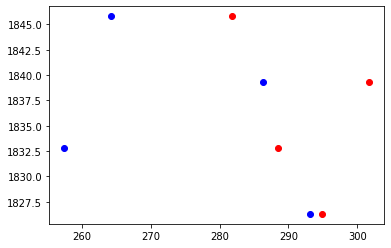

In [167]:
plt.scatter(c.xr, c.z, c = "red")
plt.scatter(c.xl, c.z, c = "blue");

In [168]:
# @njit 
# def numba_score(combin,eventZ) :
#     s = np.zeros(combin.shape[0]) 
#     for i, c in enumerate(combin) :
#         if ((eventZ - eventZ.mean())**2).sum() == 0 : # dice che se no ci sono delle divisioni per zero anche se non riesco a riprodurle a mano... assurdo
#             s[i] = 0 #np.nan
#         else :
#             slope = ((eventZ - eventZ.mean())*(c - c.mean())).sum() / ((eventZ - eventZ.mean())**2).sum()
#             intercept = c.mean() - slope*eventZ.mean() # cfr https://en.wikipedia.org/wiki/Simple_linear_regression con x e y scambiati

#             s[i] = np.linalg.norm(c - (slope*eventZ+intercept))
#     return s

# ok, credo che servisse quel protector per compensare la mancanza del filtro che rimuove eventi con più celle attive nello stesso layer
@njit 
def numba_score(combin,eventZ) :
    s = np.zeros(combin.shape[0]) 
    for i, c in enumerate(combin) :
        slope = ((eventZ - eventZ.mean())*(c - c.mean())).sum() / ((eventZ - eventZ.mean())**2).sum()
        intercept = c.mean() - slope*eventZ.mean() # cfr https://en.wikipedia.org/wiki/Simple_linear_regression con x e y scambiati

        s[i] = np.linalg.norm(c - (slope*eventZ+intercept))
    return s




def solve_ambiguity(event):
    combin = np.array(list(product(*event.loc[:, ['xr','xl']].to_numpy())))
    s = numba_score(combin,event.z.to_numpy())
    event['xb'] = combin[s.argmin()]
    return event

In [169]:
# df2 = df2.reset_index().groupby(["ORBIT_CNT","EVENT"], group_keys=False).apply(solve_ambiguity2) #reset_index() is needed to make this work
# df2 = df2.set_index(["ORBIT_CNT","EVENT"])
# df2
c = c.groupby(['orbit', 'chamber']).apply(solve_ambiguity) # tutto va fatto localmente per ora (sia nello spazio che nel tempo!)
c

,orbit,chamber,layer,center,dt,xr,xl,z,xb
7,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400
8,1118948,3,4,13,163.033333,281.771193,264.228807,1845.8,281.771193
9,1118948,3,3,14,142.200000,301.650360,286.349640,1839.3,286.349640
10,1118948,3,2,13,288.033333,288.496193,257.503807,1832.8,288.496193


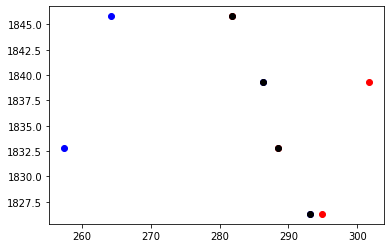

In [170]:
plt.scatter(c.xr, c.z, c = "red")
plt.scatter(c.xl, c.z, c = "blue")
plt.scatter(c.xb, c.z, c = "black");

In [171]:
df5 = df4.copy()
df5 = df5.groupby(['orbit', 'chamber']).apply(solve_ambiguity)
df5

,orbit,chamber,layer,center,dt,xr,xl,z,xb
0,1118948,1,1,22,127.233333,468.845153,455.154847,983.8,455.154847
1,1118948,1,2,21,328.700000,458.684060,423.315940,990.3,458.684060
2,1118948,1,4,23,347.866667,501.715227,464.284773,1003.3,464.284773
3,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027
4,1118948,2,4,23,92.800000,487.992640,478.007360,1061.6,487.992640
...,...,...,...,...,...,...,...,...,...
6614,10515923,0,2,19,344.733333,417.546653,380.453347,232.8,380.453347
6615,10515923,2,2,21,68.833333,444.703233,437.296767,1048.6,444.703233
6616,10515923,2,4,21,95.300000,446.127140,435.872860,1061.6,446.127140
6617,10515923,2,3,22,318.833333,479.153233,444.846767,1055.1,444.846767


In [36]:
# for index, subframe in tqdm(df4.groupby(['orbit', 'chamber'])) :
#    display(solve_ambiguity(subframe))

In [37]:
# ve = df4.loc[df4.orbit == df4.orbit.unique()[35]].sort_values('chamber').z.to_numpy().reshape((-1,4))
# ve

In [38]:
# for i in range(3) :
#     print(((ve[i] - ve[i].mean())**2).sum())

In [39]:
# df5.loc[df5.orbit == df5.orbit.unique()[35]]

In [40]:
# tutti questi sort non mi servono, ma non fa niente perché questa cella era solo un test (infatti ha un hardcoding che fa schifo! Orbita 35: 4 eventi per camera, 3 camere)
# quanto scritto qua sopra valeva solo quando per sbaglio all'inizio c'era < 15 anziché < 16

# vxr = df5.loc[df5.orbit == df5.orbit.unique()[35]].sort_values('chamber').xr.to_numpy().reshape((-1, 4))
# vxl = df5.loc[df5.orbit == df5.orbit.unique()[35]].sort_values('chamber').xl.to_numpy().reshape((-1, 4))
# vxb = df5.loc[df5.orbit == df5.orbit.unique()[35]].sort_values('chamber').xb.to_numpy().reshape((-1, 4))
# vz = df5.loc[df5.orbit == df5.orbit.unique()[35]].sort_values('chamber').z.to_numpy().reshape((-1, 4))
# for i in range(3) :
#     fig, ax = plt.subplots()
#     ax.scatter(vxl[i], vz[i], c = 'blue')
#     ax.scatter(vxr[i], vz[i], c = 'red')
#     ax.scatter(vxb[i], vz[i], c = 'black')

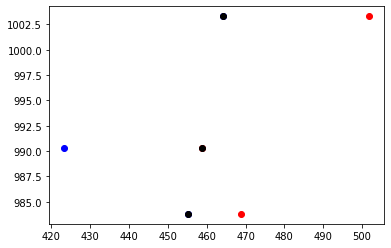

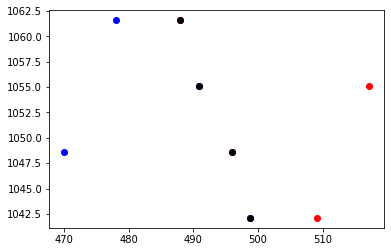

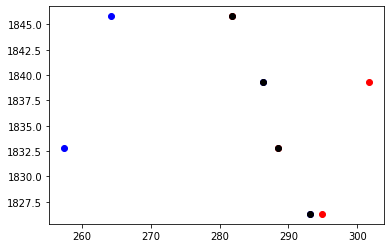

In [172]:
n = 0 # numero orbita da visualizzare
tmp = df5.loc[df5.orbit == df5.orbit.unique()[n]]#.sort_values('chamber') # a che mi serve questo sort? Tanto ad ogni x accoppio la sua z... boh

# voglio una riga per camera, ciascuna contenente tutte le hits di quella camera

# vxr = tmp.xr.to_numpy().reshape((-1, 4))
# vxl = tmp.xl.to_numpy().reshape((-1, 4))
# vxb = tmp.xb.to_numpy().reshape((-1, 4))
# vz = tmp.z.to_numpy().reshape((-1, 4))
# for i in range(3) :
#     fig, ax = plt.subplots()
#     ax.scatter(vxl[i], vz[i], c = 'blue')
#     ax.scatter(vxr[i], vz[i], c = 'red')
#     ax.scatter(vxb[i], vz[i], c = 'black')

for ch in tmp.chamber.unique() :
    vxr = tmp[tmp.chamber == ch].xr
    vxl = tmp[tmp.chamber == ch].xl
    vxb = tmp[tmp.chamber == ch].xb
    vz = tmp[tmp.chamber == ch].z

    fig, ax = plt.subplots()
    ax.scatter(vxl, vz, c = 'blue')
    ax.scatter(vxr, vz, c = 'red')
    ax.scatter(vxb, vz, c = 'black')


In [173]:
# si può fare una funzione "fit" che calcoli pendenza e intercetta (njit); questa stessa può essere usata sia per il calcolo del chi quadro che riciclata per il fit globale

***
### Il filtro della vicinanza orizzontale che fine ha fatto? Viene soppiantato dal filtro di non più di una cella attiva per layer? Verificare
***
Risposta: no. Al massimo può venire rimpiazzato da quello dei < 8 eventi per orbita, ora controllo

In [174]:
df2d = df5.copy() # pronti per il fit globale 2D; tolgo la camera 1 che è rilevante solo per quello 3d
df2d = df2d[df2d['chamber'] != 1]
df2d

,orbit,chamber,layer,center,dt,xr,xl,z,xb
3,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027
4,1118948,2,4,23,92.800000,487.992640,478.007360,1061.6,487.992640
5,1118948,2,3,24,243.833333,517.118233,490.881767,1055.1,490.881767
6,1118948,2,2,23,240.500000,495.938900,470.061100,1048.6,495.938900
7,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400
...,...,...,...,...,...,...,...,...,...
6614,10515923,0,2,19,344.733333,417.546653,380.453347,232.8,380.453347
6615,10515923,2,2,21,68.833333,444.703233,437.296767,1048.6,444.703233
6616,10515923,2,4,21,95.300000,446.127140,435.872860,1061.6,446.127140
6617,10515923,2,3,22,318.833333,479.153233,444.846767,1055.1,444.846767


In [175]:
# ALTERNATIVA SENZA ISIN (più dask-friendly): qualcosa tipo la seguente

def filtro2d(gruppo) :
    if len(gruppo['chamber'].unique()) > 1 :
        return gruppo
    else : 
        return None

df2d_altro = df2d.groupby("orbit").apply(filtro2d).reset_index(drop = True).dropna()
df2d_altro

,orbit,chamber,layer,center,dt,xr,xl,z,xb
0,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027
1,1118948,2,4,23,92.800000,487.992640,478.007360,1061.6,487.992640
2,1118948,2,3,24,243.833333,517.118233,490.881767,1055.1,490.881767
3,1118948,2,2,23,240.500000,495.938900,470.061100,1048.6,495.938900
4,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400
...,...,...,...,...,...,...,...,...,...
3038,10515923,0,2,19,344.733333,417.546653,380.453347,232.8,380.453347
3039,10515923,2,2,21,68.833333,444.703233,437.296767,1048.6,444.703233
3040,10515923,2,4,21,95.300000,446.127140,435.872860,1061.6,446.127140
3041,10515923,2,3,22,318.833333,479.153233,444.846767,1055.1,444.846767


Importantissimo ri-assicurarsi che ogni coppia orbita/camera contenga almeno 3 punti per il fit (cosa non più scontata avendo rimosso la camera 1)!! Se no possono esserci orbite con un solo punto che soddisfano z == z.mean() banalmente!!

In [177]:
#df2d = df2d_altro.copy()

In [181]:
df2d.groupby('orbit').size()[df2d.groupby('orbit').size() > 2].index

UInt64Index([ 1118948,  1123056,  1124284,  1126947,  1130581,  1135298,
              1144838,  1151335,  1175583,  1190501,
             ...
             10247653, 10289800, 10312471, 10323733, 10336841, 10402754,
             10461215, 10497098, 10498956, 10515923],
            dtype='uint64', name='orbit', length=390)

In [182]:
S = df2d.groupby('orbit').size()
Si = S[S > 2].index
df2d = df2d[df2d.orbit.isin(Si)] # l'indice di S è orbit!!
df2d

,orbit,chamber,layer,center,dt,xr,xl,z,xb
0,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027
1,1118948,2,4,23,92.800000,487.992640,478.007360,1061.6,487.992640
2,1118948,2,3,24,243.833333,517.118233,490.881767,1055.1,490.881767
3,1118948,2,2,23,240.500000,495.938900,470.061100,1048.6,495.938900
4,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400
...,...,...,...,...,...,...,...,...,...
3038,10515923,0,2,19,344.733333,417.546653,380.453347,232.8,380.453347
3039,10515923,2,2,21,68.833333,444.703233,437.296767,1048.6,444.703233
3040,10515923,2,4,21,95.300000,446.127140,435.872860,1061.6,446.127140
3041,10515923,2,3,22,318.833333,479.153233,444.846767,1055.1,444.846767


In [183]:
# test
df2d.groupby(['orbit']).nunique()

,chamber,layer,center,dt,xr,xl,z,xb
orbit,,,,,,,,
1118948,2,4,4,8,8,8,8,8
1123056,2,4,5,8,8,8,8,8
1124284,2,4,4,8,8,8,8,8
1126947,2,4,4,8,8,8,8,8
1130581,2,4,4,7,7,7,7,7
...,...,...,...,...,...,...,...,...
10402754,2,4,4,7,7,7,7,7
10461215,3,4,7,10,10,10,10,10
10497098,2,4,2,8,8,8,8,8


In [184]:
# test
df2d['orbit'].unique().shape[0] # numero di orbite uniche

390

In [185]:
# test
df2d.groupby(['orbit']).nunique()['chamber'] > 1 # quali di queste 295 orbite hanno almeno 2 valori distinti di chamber?

orbit
1118948     True
1123056     True
1124284     True
1126947     True
1130581     True
            ... 
10402754    True
10461215    True
10497098    True
10498956    True
10515923    True
Name: chamber, Length: 390, dtype: bool

In [186]:
# test
print(df2d['orbit'].unique()[df2d.groupby(['orbit']).nunique()['chamber'] > 1].shape[0])
df2d['orbit'].unique()[df2d.groupby(['orbit']).nunique()['chamber'] > 1]

390


array([ 1118948,  1123056,  1124284,  1126947,  1130581,  1135298,
        1144838,  1151335,  1175583,  1190501,  1248672,  1273848,
        1324275,  1340132,  1359360,  1378974,  1457838,  1494528,
        1510870,  1526415,  1563057,  1580971,  1589457,  1616334,
        1627535,  1647343,  1652809,  1678645,  1689723,  1691363,
        1696794,  1701734,  1776978,  1777546,  1785150,  1800192,
        1807938,  1843749,  1865842,  1875545,  1875743,  1875773,
        1906563,  1915299,  1974647,  1980146,  2000410,  2040732,
        2175677,  2194162,  2229354,  2243090,  2310920,  2336876,
        2345052,  2355233,  2399681,  2422956,  2468012,  2493277,
        2503604,  2556847,  2565416,  2578826,  2673209,  2684383,
        2698072,  2730461,  2734116,  2751422,  2752751,  2781075,
        2898095,  2933770,  2939904,  2972885,  2976721,  3005472,
        3049467,  3065545,  3094166,  3129186,  3144497,  3175239,
        3197532,  3213892,  3222537,  3308419,  3315584,  3329

In [187]:
# da df2d devo togliere le orbite che non abbiano almeno 2 camere (senza contare 1 che ho tolto, ovviamente)
df2d = df2d[df2d.orbit.isin(df2d['orbit'].unique()[df2d.groupby(['orbit']).nunique()['chamber'] > 1])]
df2d

,orbit,chamber,layer,center,dt,xr,xl,z,xb
0,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027
1,1118948,2,4,23,92.800000,487.992640,478.007360,1061.6,487.992640
2,1118948,2,3,24,243.833333,517.118233,490.881767,1055.1,490.881767
3,1118948,2,2,23,240.500000,495.938900,470.061100,1048.6,495.938900
4,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400
...,...,...,...,...,...,...,...,...,...
3038,10515923,0,2,19,344.733333,417.546653,380.453347,232.8,380.453347
3039,10515923,2,2,21,68.833333,444.703233,437.296767,1048.6,444.703233
3040,10515923,2,4,21,95.300000,446.127140,435.872860,1061.6,446.127140
3041,10515923,2,3,22,318.833333,479.153233,444.846767,1055.1,444.846767


A giudicare dalla len df2d e df2d_altro sono uguali, buono

In [188]:
@njit
def fit(z, x) : # ricorda: nel nostro fit (rispetto a wikipedia) si ha x -> z (variabile fissa/senza errore/senza osservazioni da confrontare con predizioni) e y -> x (tutto il contrario dell'altra)
    slope = ((z - z.mean())*(x - x.mean())).sum() / ((z - z.mean())**2).sum()
    intercept = x.mean() - slope * z.mean()
    return slope, intercept # geometricamente queste due sono "sbagliate" ma filosoficamente e numericamente no!
    # questi due parametri soddisfano l'equazione x = slope*z+intercept visto quanto detto sopra su x, y e z

In [189]:
df2d[df2d.orbit == df2d.orbit.unique()[0]] # nota che i valori di z sono già globali!!

,orbit,chamber,layer,center,dt,xr,xl,z,xb
0,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027
1,1118948,2,4,23,92.800000,487.992640,478.007360,1061.6,487.992640
2,1118948,2,3,24,243.833333,517.118233,490.881767,1055.1,490.881767
3,1118948,2,2,23,240.500000,495.938900,470.061100,1048.6,495.938900
4,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400
5,1118948,3,4,13,163.033333,281.771193,264.228807,1845.8,281.771193
6,1118948,3,3,14,142.200000,301.650360,286.349640,1839.3,286.349640
7,1118948,3,2,13,288.033333,288.496193,257.503807,1832.8,288.496193


In [190]:
def plot_global_fit(event) :
    vxb = event.xb.to_numpy()
    vz = event.z.to_numpy()

    slope, intercept = fit(vz, vxb) # faccio il fit solo con le x best!
    q = -intercept/slope 
    m = 1/slope # cfr notebook di Zanetti per vedere come "raddrizzare" GEOMETRICAMENTE la retta (riflessione ortogonale)

    fig, ax = plt.subplots()
    ax.scatter(vxb, vz, c = 'black')
    ax.plot(vxb, m*vxb + q)
    ax.set_title(f'orbit {event.orbit.iloc[0]}') # nello stesso evento per definizione tutte le orbite sono uguali, basta la prima con iloc anziché unique ecc.
    ax.set_yticks(z_offset) # le altezze delle camere (le due centrali sono appiccicate)

In [191]:
print('unique number of orbits:', df2d.orbit.unique().shape[0])

unique number of orbits: 390


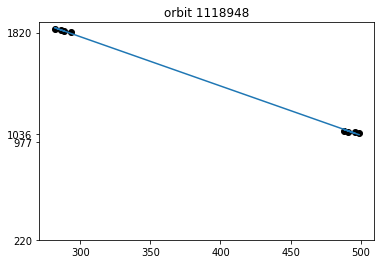

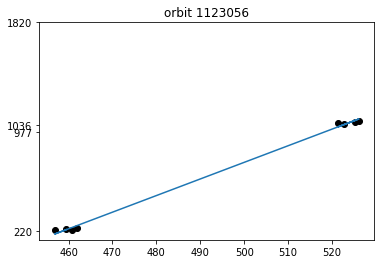

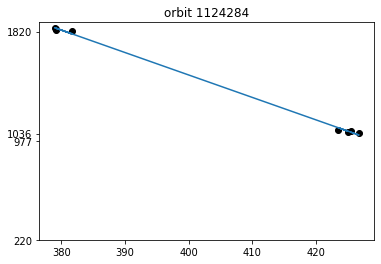

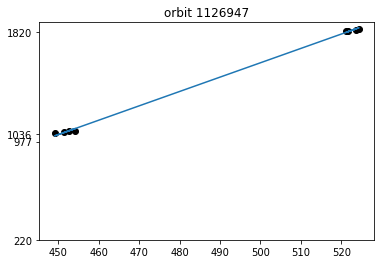

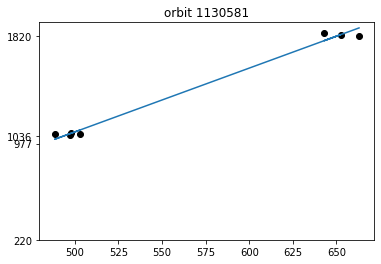

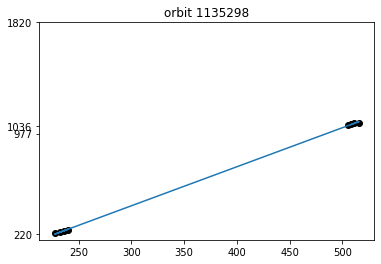

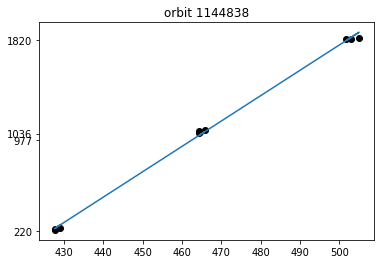

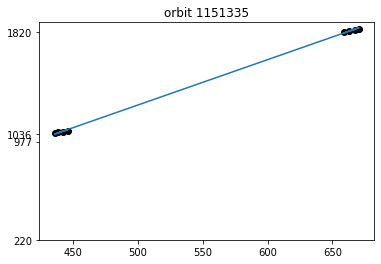

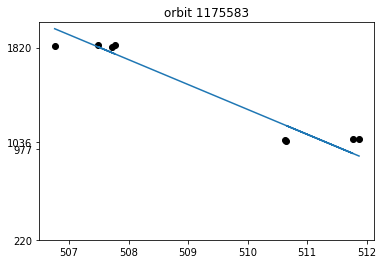

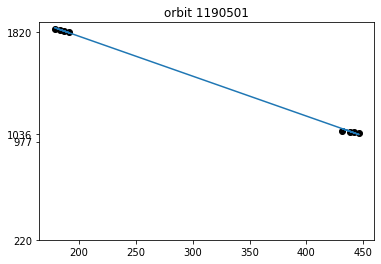

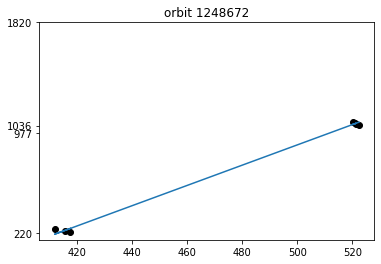

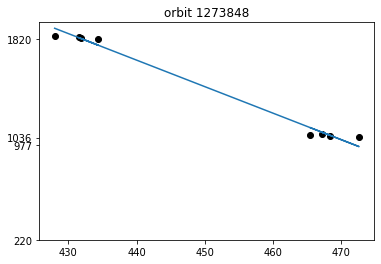

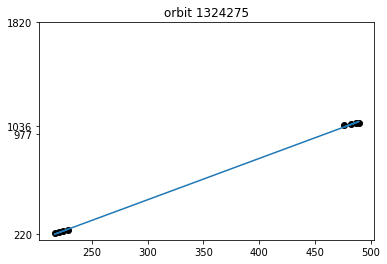

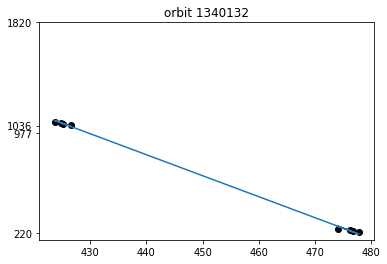

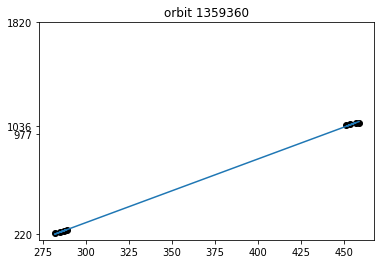

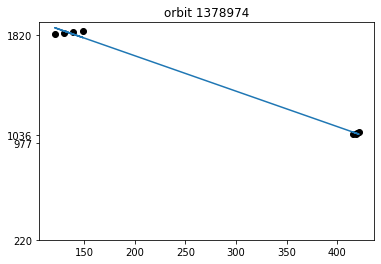

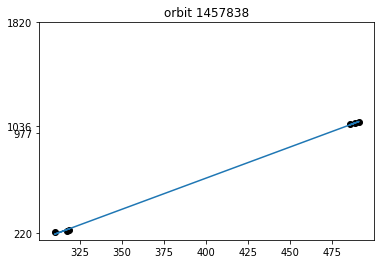

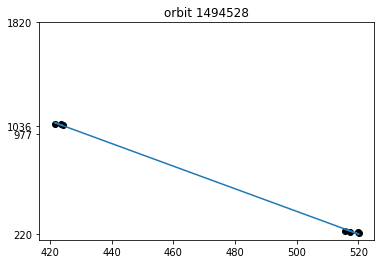

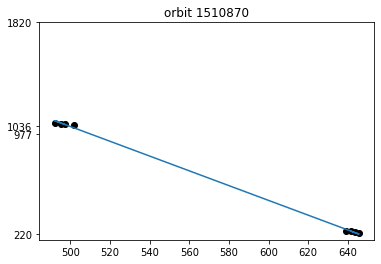

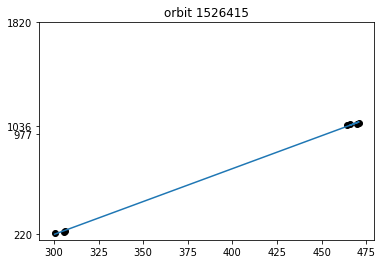

In [192]:
for i in range(20) :
    plot_global_fit(df2d[df2d.orbit == df2d.orbit.unique()[i]])

In [193]:
df2d[df2d.orbit == 1175583]

,orbit,chamber,layer,center,dt,xr,xl,z,xb
65,1175583,2,3,24,146.333333,511.872733,496.127267,1055.1,511.872733
66,1175583,2,1,24,123.633333,510.651473,497.348527,1042.1,510.651473
67,1175583,2,4,25,245.933333,538.231213,511.768787,1061.6,511.768787
68,1175583,2,2,25,267.166667,539.373567,510.626433,1048.6,510.626433
69,1175583,3,3,24,64.900000,507.491620,500.508380,1839.3,507.491620
70,1175583,3,1,24,69.066667,507.715787,500.284213,1826.3,507.715787
71,1175583,3,4,25,320.333333,542.233933,507.766067,1845.8,507.766067
72,1175583,3,2,25,339.066667,543.241787,506.758213,1832.8,506.758213


## Serve la vicinanza orizzontale
Intanto però vediamo se i residui possano essere usati in tal senso

In [194]:
def residui(gruppo) :
    # nota importante: come detto dal tipo della tesi è interessante calcolare i residui definiti rispetto al fit *globale*
    slope, intercept = fit(gruppo['z'].to_numpy(), gruppo['xb'].to_numpy()) # infatti qui fitto sui dati già senza ambiguità...
    gruppo['residui'] = gruppo['xb'] - slope*gruppo['z']-intercept # x osservato - x predetto
    return gruppo 

df2d_2 = df2d.groupby('orbit').apply(residui).reset_index(drop = True) # ...e qui NON raggruppo per chamber
df2d_2

,orbit,chamber,layer,center,dt,xr,xl,z,xb,residui
0,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027,2.814740
1,1118948,2,4,23,92.800000,487.992640,478.007360,1061.6,487.992640,-2.896574
2,1118948,2,3,24,243.833333,517.118233,490.881767,1055.1,490.881767,-1.715472
3,1118948,2,2,23,240.500000,495.938900,470.061100,1048.6,495.938900,1.633637
4,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400,3.138674
...,...,...,...,...,...,...,...,...,...,...
3038,10515923,0,2,19,344.733333,417.546653,380.453347,232.8,380.453347,1.319481
3039,10515923,2,2,21,68.833333,444.703233,437.296767,1048.6,444.703233,0.436871
3040,10515923,2,4,21,95.300000,446.127140,435.872860,1061.6,446.127140,0.822873
3041,10515923,2,3,22,318.833333,479.153233,444.846767,1055.1,444.846767,0.061452


4.679503262477133e-13


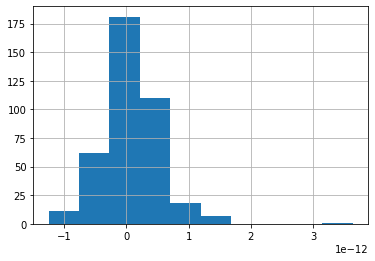

In [195]:
s = df2d_2.groupby('orbit').apply(lambda gruppo: gruppo.residui.sum())
print(s.std())
s.hist();
# assolutamente inutile (sono tutti 0 stando ai float ecc.), il che conferma che effettivamente quella di somma dei residui = 0 è una identità soddisfatta sempre per via di come calcolo alpha e beta, non eliminata da rumore o eventuali errori casuali/sistematici

In [196]:
s1 = df2d_2.groupby('chamber').apply(lambda gruppo: gruppo.residui)
s1#.hist();

chamber      
0        8      -0.476486
         9      -2.133512
         10      1.230708
         11      1.451406
         39     -0.877023
                   ...   
3        3018    2.138589
         3031   -1.736540
         3032    4.882970
         3033   -4.277918
         3034    1.308632
Name: residui, Length: 3043, dtype: float64

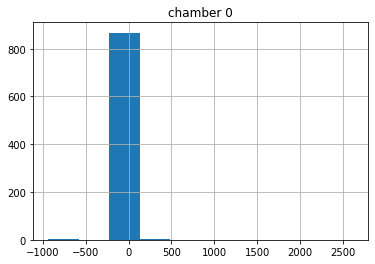

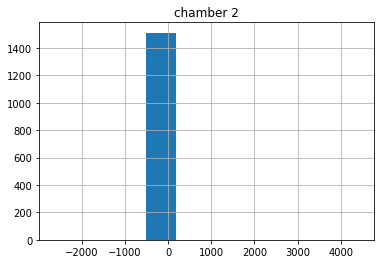

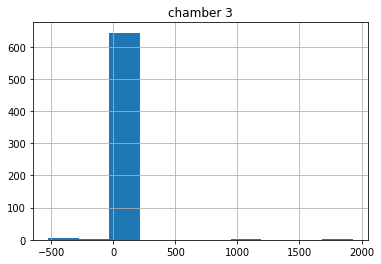

In [197]:
for i in [0, 2, 3] :
    plt.figure();
    s1[i].hist();
    plt.title(f'chamber {i}')

Chamber 2 nell'istogramma precedente: praticamente come al caruso. Camere 0 e 3: sballate dal non aver tolto quelli che non rispettano la vicinanza orizzontale!          
In ogni caso questo modo di procedere è effettivamente migliore del precedente, visto che sommando i residui relativi solo ad una camera (quindi non tutti) non ottengo necessariamente 0, anzi in generale tutt'altro!

P.S. ovviamente la camera 1 è stata esclusa da questo discorso

In [198]:
for i in [0, 2, 3] : # non c'è 1
    print('std ch.', i, '->', s1[i].std()) # e infatti le camere sballate hanno sigma enormi

std ch. 0 -> 104.85520135966281
std ch. 2 -> 150.17700329254578
std ch. 3 -> 98.45647188704118


In [199]:
# e se provassi ad eliminare la spazzatura ricorrendo ai residui stessi?
df2d_3 = df2d_2[df2d_2.residui.abs() < 15] # valore indicativo, un po' inventato in realtà. Sarebbe meglio stimarlo sulla base dell'errore accettabile!
df2d_3

,orbit,chamber,layer,center,dt,xr,xl,z,xb,residui
0,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027,2.814740
1,1118948,2,4,23,92.800000,487.992640,478.007360,1061.6,487.992640,-2.896574
2,1118948,2,3,24,243.833333,517.118233,490.881767,1055.1,490.881767,-1.715472
3,1118948,2,2,23,240.500000,495.938900,470.061100,1048.6,495.938900,1.633637
4,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400,3.138674
...,...,...,...,...,...,...,...,...,...,...
3038,10515923,0,2,19,344.733333,417.546653,380.453347,232.8,380.453347,1.319481
3039,10515923,2,2,21,68.833333,444.703233,437.296767,1048.6,444.703233,0.436871
3040,10515923,2,4,21,95.300000,446.127140,435.872860,1061.6,446.127140,0.822873
3041,10515923,2,3,22,318.833333,479.153233,444.846767,1055.1,444.846767,0.061452


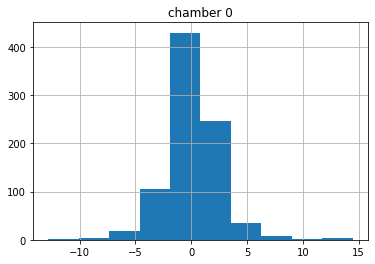

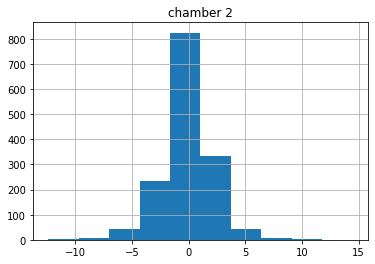

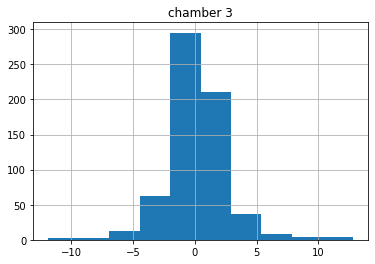

In [200]:
s2 = df2d_3.groupby('chamber').apply(lambda gruppo: gruppo.residui)

for i in [0, 2, 3] : # le uniche camere che ho a disposizione se manca la 1
    plt.figure();
    s2[i].hist();
    plt.title(f'chamber {i}');

In [201]:
for i in [0, 2, 3] : # non c'è 1
    print('std ch.', i, '->', s2[i].std())

std ch. 0 -> 2.4684486179382628
std ch. 2 -> 2.278996092083152
std ch. 3 -> 2.5009587523744283


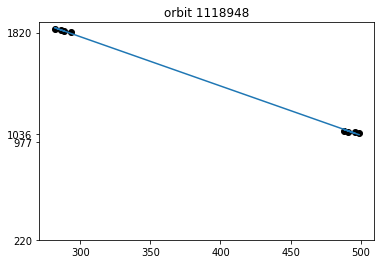

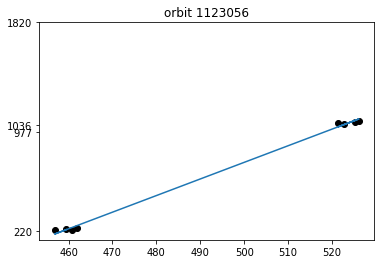

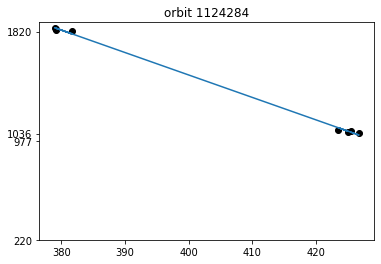

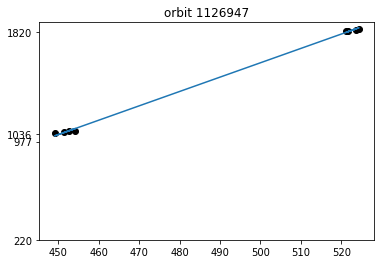

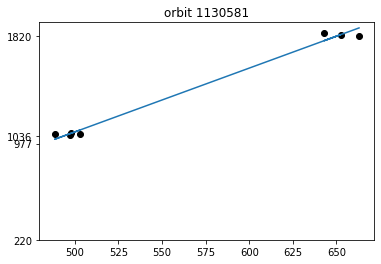

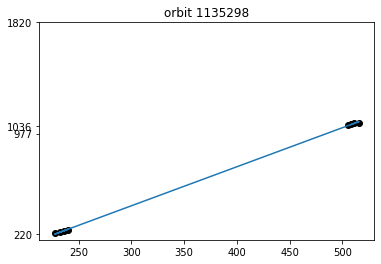

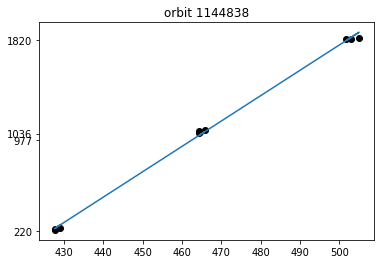

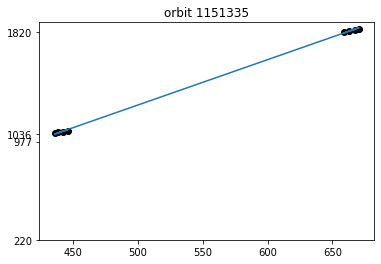

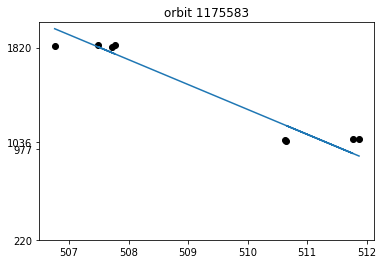

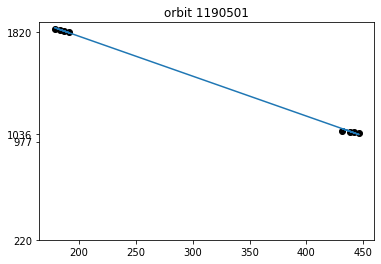

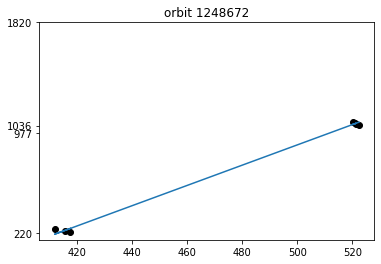

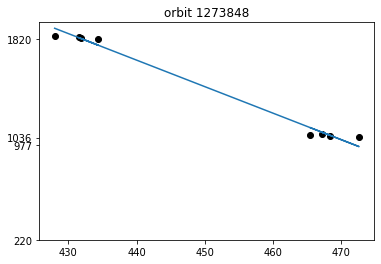

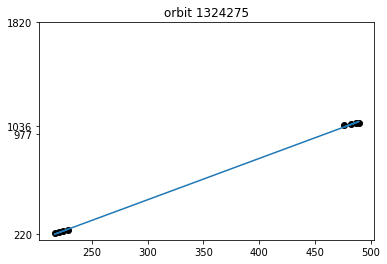

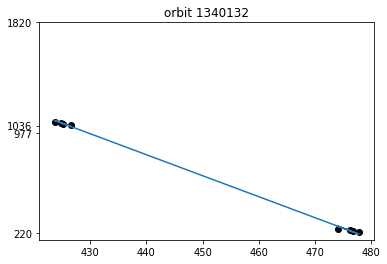

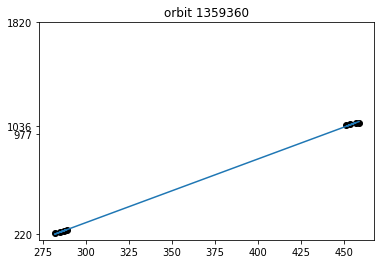

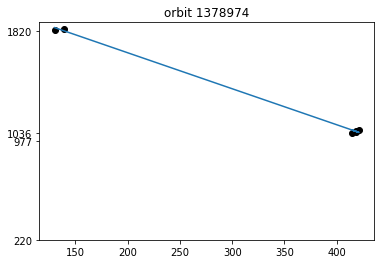

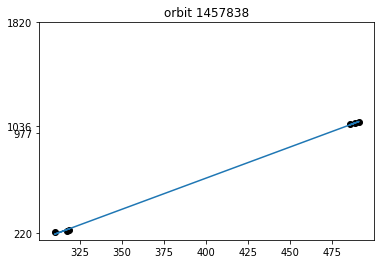

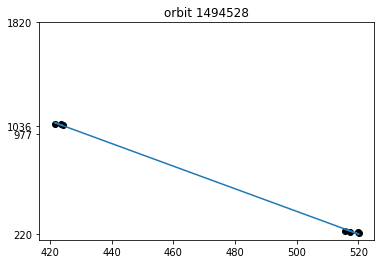

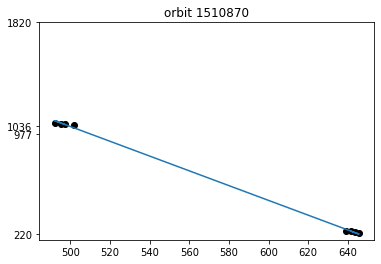

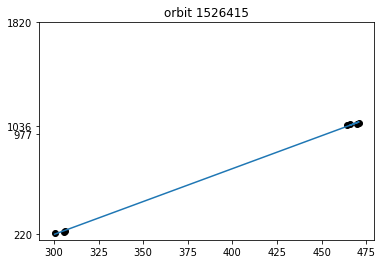

In [202]:
for i in range(20) :
    plot_global_fit(df2d_3[df2d_3.orbit == df2d_3.orbit.unique()[i]])

l'orbita 1273848 comunque si comporta male, mm... Un sigma più stringente?

In [203]:
df2d_4 = df2d_2[df2d_2.residui.abs() < 10] # valore indicativo, un po' inventato in realtà. Sarebbe meglio stimarlo sulla base dell'errore accettabile!
df2d_4

,orbit,chamber,layer,center,dt,xr,xl,z,xb,residui
0,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027,2.814740
1,1118948,2,4,23,92.800000,487.992640,478.007360,1061.6,487.992640,-2.896574
2,1118948,2,3,24,243.833333,517.118233,490.881767,1055.1,490.881767,-1.715472
3,1118948,2,2,23,240.500000,495.938900,470.061100,1048.6,495.938900,1.633637
4,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400,3.138674
...,...,...,...,...,...,...,...,...,...,...
3038,10515923,0,2,19,344.733333,417.546653,380.453347,232.8,380.453347,1.319481
3039,10515923,2,2,21,68.833333,444.703233,437.296767,1048.6,444.703233,0.436871
3040,10515923,2,4,21,95.300000,446.127140,435.872860,1061.6,446.127140,0.822873
3041,10515923,2,3,22,318.833333,479.153233,444.846767,1055.1,444.846767,0.061452


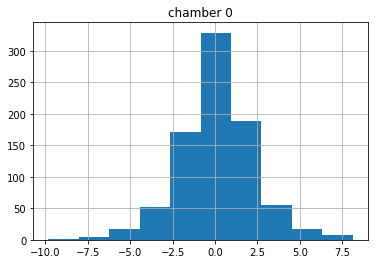

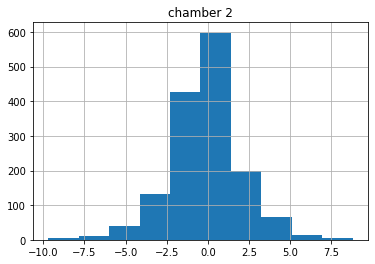

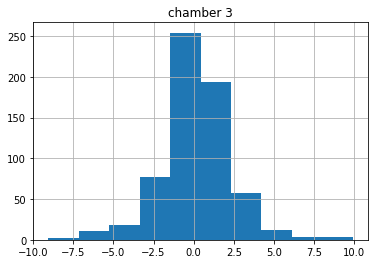

In [204]:
s3 = df2d_4.groupby('chamber').apply(lambda gruppo: gruppo.residui)

for i in [0, 2, 3] : # le uniche camere che ho a disposizione se manca la 1
    plt.figure();
    s3[i].hist();
    plt.title(f'chamber {i}');

In [205]:
for i in [0, 2, 3] : # non c'è 1
    print('std ch.', i, '->', s3[i].std())

std ch. 0 -> 2.18300047345713
std ch. 2 -> 2.139448839291211
std ch. 3 -> 2.2301735025000498


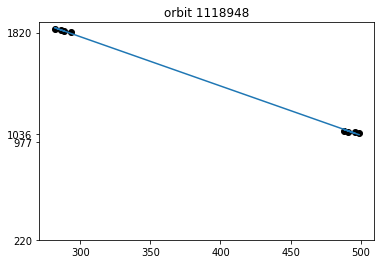

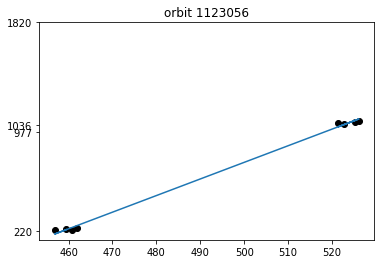

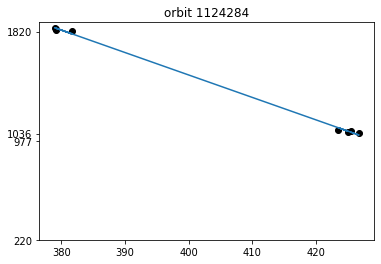

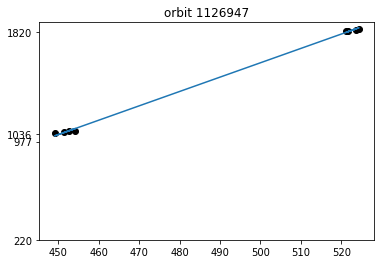

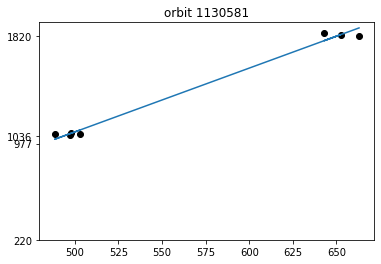

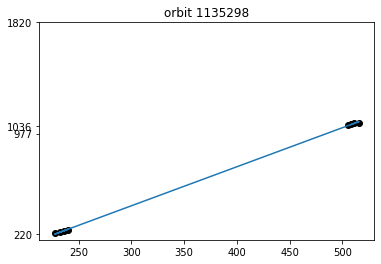

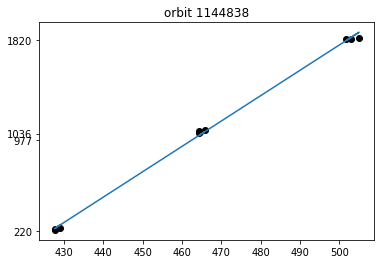

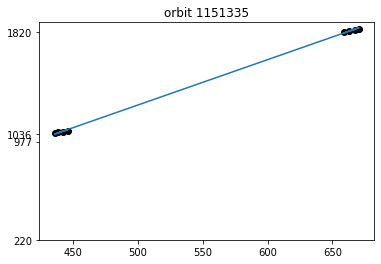

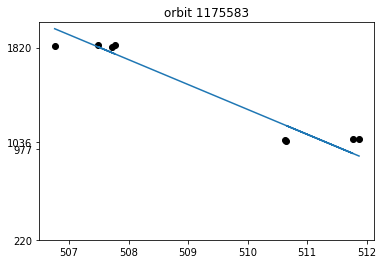

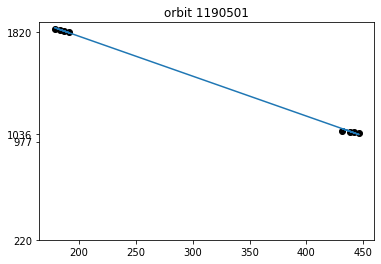

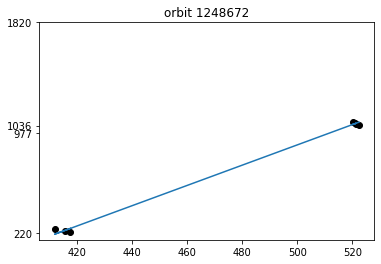

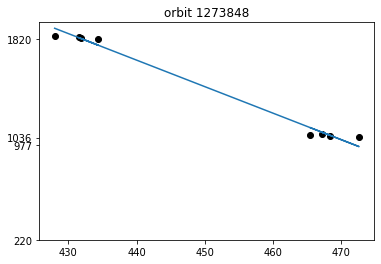

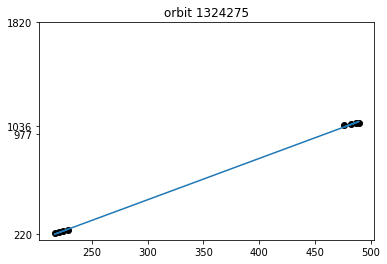

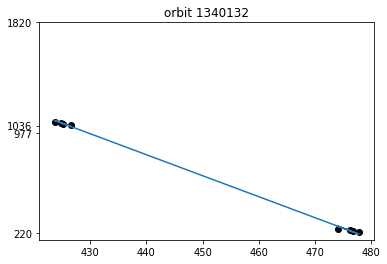

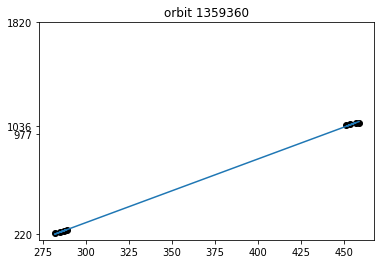

In [206]:
for i in range(15) :
    plot_global_fit(df2d_3[df2d_3.orbit == df2d_3.orbit.unique()[i]]) # ancora passa quella disgraziata, grrr

# Fit 3d: non scarto 1 e anzi chiedo che ci sia almeno un'altra camera

In [69]:
df3d = df5.copy()

def filtro3d(gruppo) :
    if 1 in gruppo.chamber.unique() and len(gruppo.chamber.unique()) > 2 : # mi serve ad esempio 0-1 per yz e 0-2 per xz, quindi camera 1 + almeno altre 2. Questo significa minimo 3 in totale!
        return gruppo 
    else :
        return None

df3d = df3d.groupby('orbit').apply(filtro3d).reset_index(drop = True).dropna()
df3d # ovviamente c'è molta più roba

,orbit,chamber,layer,center,dt,xr,xl,z,xb
0,1118948,1,1,22,127.233333,468.845153,455.154847,983.8,455.154847
1,1118948,1,2,21,328.700000,458.684060,423.315940,990.3,458.684060
2,1118948,1,4,23,347.866667,501.715227,464.284773,1003.3,464.284773
3,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027
4,1118948,2,4,23,92.800000,487.992640,478.007360,1061.6,487.992640
...,...,...,...,...,...,...,...,...,...
3489,10497098,1,3,20,326.400000,437.560320,402.439680,996.8,437.560320
3490,10497098,2,3,22,70.900000,465.814420,458.185580,1055.1,458.185580
3491,10497098,2,1,22,68.200000,465.669160,458.330840,1042.1,458.330840
3492,10497098,2,4,21,367.566667,460.775087,421.224913,1061.6,460.775087


In [70]:
#cella copiata da sopra; la rimetto qui per avere un blueprint per quella 3d e per poter fare eventuali modifiche alla stessa senza dover risalire 100 volte
def plot_global_fit(event) :
    vxb = event.xb.to_numpy()
    vz = event.z.to_numpy()

    slope, intercept = fit(vz, vxb) # faccio il fit solo con le x best!
    q = -intercept/slope 
    m = 1/slope # cfr notebook di Zanetti per vedere come "raddrizzare" GEOMETRICAMENTE la retta (riflessione ortogonale)

    fig, ax = plt.subplots()
    ax.scatter(vxb, vz, c = 'black')
    ax.plot(vxb, m*vxb + q)
    ax.set_title(f'orbit {event.orbit.iloc[0]}')
    ax.set_yticks(z_offset) # le altezze delle camere (le due centrali sono appiccicate)

    ax.axis('equal')

In [71]:
# temo si possa graficare solo la retta! Infatti per le hits abbiamo solo x e z o y e z, mai tutti e tre insieme

def plot_3d(event) :
    vx = event[event.chamber != 1].xb.to_numpy()
    vzx = event[event.chamber != 1].z.to_numpy()

    vy = event[event.chamber == 1].xb.to_numpy()
    vzy = event[event.chamber == 1].z.to_numpy()

    # formule per mettere insieme le due pendenze sui due piani... (magari di intercept fai la media? O magari stampa solamente di quanto differiscono i due)
    m1, q1 = fit(vzx, vx)
    m2, q2 = fit(vzy, vy)

    #return m1, m2, -q1/m1, -q2/m2
    t = np.linspace(170, 2000) # z è sempre più o meno fra 200 e 1840, ma allungo un po'
    #t = np.linspace(-2000, 100)
    X = q1 + m1*t
    Y = q2 + m2*t
    Z = t 
    fig = px.line_3d(x = X, y = Y, z = Z) # creo la figura di go con una sola chiamata semplice mediante px, e poi aggiorno l'oggetto fig

    # BLOCCO SE VOGLIO SOLO LA FETTA DI SOTTO DI OGNI CAMERA
    # X_s, Y_s = np.meshgrid(np.linspace(0, 21+16*42, 10), np.linspace(0, 16*42, 10)) # X va da 0 a 21 + 42*16 (16 celle nei layer traslati), Y riguarda solo la camera 1 (quindi penso vada bene 16*42)
    # for i in range(4) : # le 4 camere
    #     fig.add_surface(x = X_s, y = Y_s, z = z_offset[i]*np.ones(X_s.shape))
    # alla fine penso che comunque vada bene anche una cosa meno raffinata come assumere semplicemente detector quadrati lunghi 42*16.5 mm per lato, con 13*4 mm di altezza

    l = 42*16.5
    X_s = [0, l, l, 0]*2
    Y_s = [0, 0, l, l]*2
    Z_s = np.array([0]*4 + [13*4]*4)
    for i in range(4) : # le 4 camere
        fig.add_mesh3d( 
            x = X_s, y = Y_s, z = Z_s + z_offset[i],
            i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2], # https://stackoverflow.com/questions/60371624/drawing-a-3d-box-in-a-3d-scatterplot-using-plotly
            j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
            k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
            opacity = 0.25,
            color = '#DC143C',
            flatshading = True # fondamentale
        )

    return fig

In [72]:
p = plot_3d(df3d.loc[df3d.orbit == df3d.orbit.unique()[0]])
p

In [73]:
#p.add_mesh3d?

In [74]:
#p.add_surface?

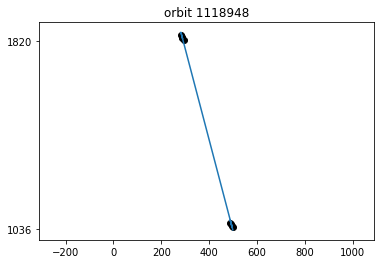

In [75]:
plot_global_fit(df3d.loc[(df3d.orbit == df3d.orbit.unique()[0]) & (df3d.chamber != 1)])

In [76]:
def plot_fit_ch1(event) :
    vyb = event.xb.to_numpy()
    vz = event.z.to_numpy()

    slope, intercept = fit(vz, vyb) # faccio il fit solo con le x best!
    q = -intercept/slope 
    m = 1/slope # cfr notebook di Zanetti per vedere come "raddrizzare" GEOMETRICAMENTE la retta (riflessione ortogonale)

    fig, ax = plt.subplots()
    ax.scatter(vyb, vz, c = 'black')
    ax.plot(vyb, m*vyb + q)
    ax.set_title(f'orbit {event.orbit.iloc[0]}')
    #ax.set_yticks(z_offset) # le altezze delle camere (le due centrali sono appiccicate)

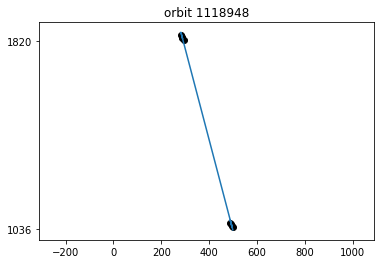

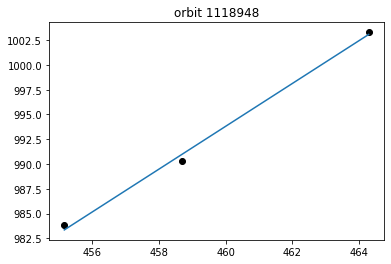

In [77]:
tmp = df3d.loc[df3d.orbit == df3d.orbit.unique()[0]]
tmp1 = tmp[tmp.chamber == 1]
tmp2 = tmp[tmp.chamber != 1]

plot_global_fit(tmp2)
plot_fit_ch1(tmp1)

In [78]:
tmp1

,orbit,chamber,layer,center,dt,xr,xl,z,xb
0,1118948,1,1,22,127.233333,468.845153,455.154847,983.8,455.154847
1,1118948,1,2,21,328.700000,458.684060,423.315940,990.3,458.684060
2,1118948,1,4,23,347.866667,501.715227,464.284773,1003.3,464.284773


In [79]:
tmp2

,orbit,chamber,layer,center,dt,xr,xl,z,xb
3,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027
4,1118948,2,4,23,92.800000,487.992640,478.007360,1061.6,487.992640
5,1118948,2,3,24,243.833333,517.118233,490.881767,1055.1,490.881767
6,1118948,2,2,23,240.500000,495.938900,470.061100,1048.6,495.938900
7,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400
8,1118948,3,4,13,163.033333,281.771193,264.228807,1845.8,281.771193
9,1118948,3,3,14,142.200000,301.650360,286.349640,1839.3,286.349640
10,1118948,3,2,13,288.033333,288.496193,257.503807,1832.8,288.496193


***
## Distanza orizzontale vs 7 eventi/orbita max
***

In [80]:
df6 = df5.copy()
df6 = df6.groupby('orbit').apply(residui).reset_index(drop = True) # residui rispetto al fit globale
df6

,orbit,chamber,layer,center,dt,xr,xl,z,xb,residui
0,1118948,1,1,22,127.233333,468.845153,455.154847,983.8,455.154847,-32.755015
1,1118948,1,2,21,328.700000,458.684060,423.315940,990.3,458.684060,-27.708210
2,1118948,1,4,23,347.866667,501.715227,464.284773,1003.3,464.284773,-19.072312
3,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027,24.529797
4,1118948,2,4,23,92.800000,487.992640,478.007360,1061.6,487.992640,18.247186
...,...,...,...,...,...,...,...,...,...,...
6614,10515923,0,2,19,344.733333,417.546653,380.453347,232.8,380.453347,1.319481
6615,10515923,2,2,21,68.833333,444.703233,437.296767,1048.6,444.703233,0.436871
6616,10515923,2,4,21,95.300000,446.127140,435.872860,1061.6,446.127140,0.822873
6617,10515923,2,3,22,318.833333,479.153233,444.846767,1055.1,444.846767,0.061452


In [81]:
s4 = df6.groupby('chamber').apply(lambda gruppo: gruppo.residui)

for i in range(4) : # ho tutte le camere a disposizione per ora
    plt.figure();
    s2[i].hist();
    plt.title(f'chamber {i}');

KeyError: 1